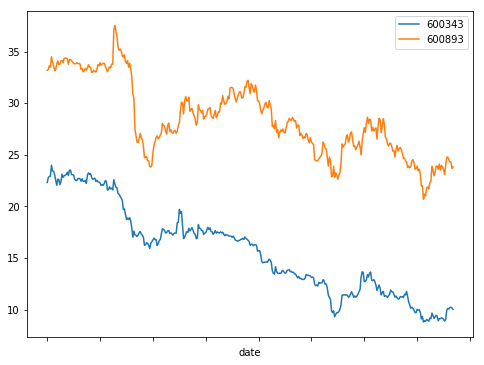

In [1]:
import pandas as pd
import numpy as np
import tushare as ts
import seaborn
%matplotlib inline
from matplotlib import pyplot as plt
stocks_pair = ['600343', '600893']   #航天动力/航发动力

#股票数据获取、回测准备
data1 = ts.get_k_data('600343', '2017-01-01', '2018-07-31')[['date','close']]
data1.set_index('date', inplace = True)
data2 = ts.get_k_data('600893', '2017-01-01', '2018-07-31')[['date','close']]
data2.set_index('date', inplace = True)

#拼接，把两张表格的数据拼接起来；
data = pd.concat([data1, data2], axis=1)               
data.columns = stocks_pair

#绘制股票走势图
data.plot(figsize= (8,6))

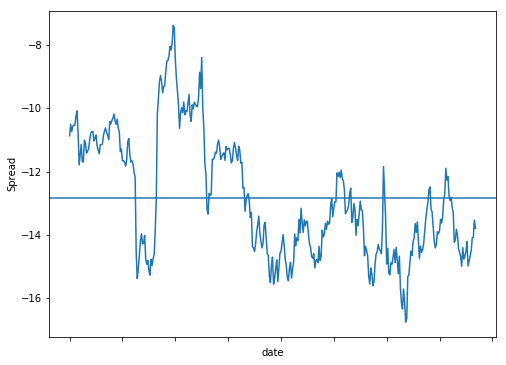

In [2]:
#策略部分
data['priceDelta']=data['600343']-data['600893']  #差价

data['priceDelta'].plot(figsize= (8,6))
plt.ylabel('Spread')
plt.axhline(data['priceDelta'].mean())

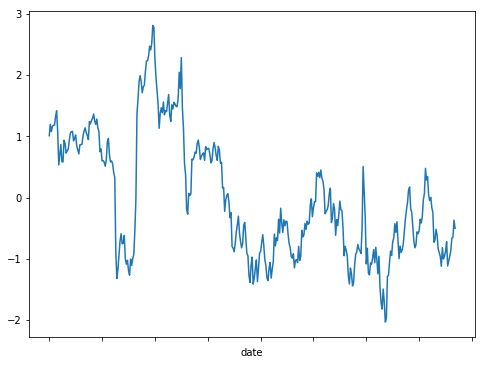

In [3]:
data['zscore'] = (data['priceDelta'] - np.mean(data['priceDelta']))/np.std(data['priceDelta'])     #价差的标准化；
data['zscore'].plot(figsize= (8,6))

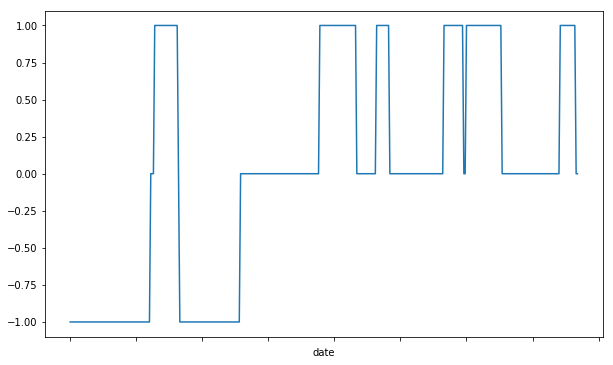

In [4]:
#开仓信号挖掘
data['position_1'] = np.where(data['zscore'] > 1, -1, np.nan)
data['position_1'] = np.where(data['zscore'] < -1, 1, data['position_1'])
data['position_1'] = np.where(abs(data['zscore']) < 0.5, 0, data['position_1'])

#开仓信号数据处理
data['position_1'] = data['position_1'].fillna(method = 'ffill')
data['position_1'] = data['position_1'].fillna(0)

#绘制股票600343开仓信号图
data['position_1'].plot(ylim=[-1.1, 1.1], figsize=(10, 6))

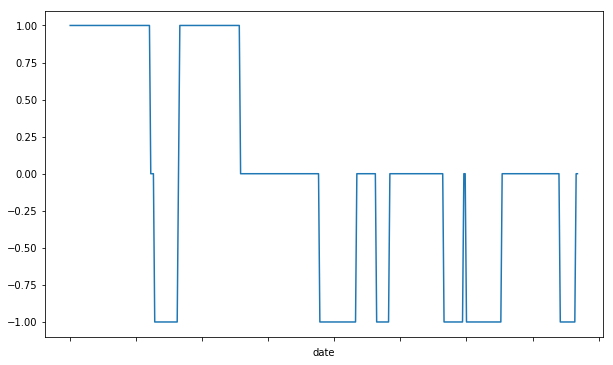

In [5]:
#绘制股票600893开仓信号图
data['position_2'] = -np.sign(data['position_1'])
data['position_2'].plot(ylim=[-1.1, 1.1], figsize=(10, 6))

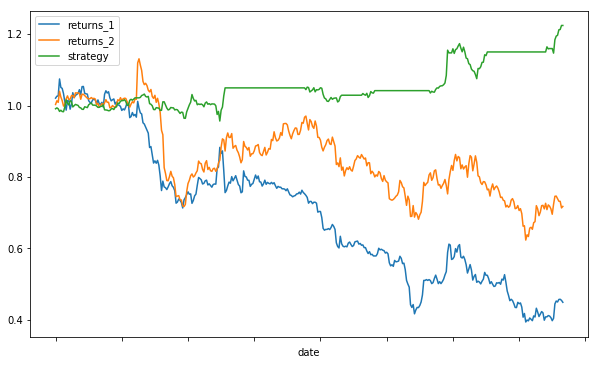

In [6]:
#计算该时间区域内收益
data['returns_1'] = np.log(data['600343'] / data['600343'].shift(1))
data['returns_2'] = np.log(data['600893'] / data['600893'].shift(1))
data['strategy'] = 0.5*(data['position_1'].shift(1) * data['returns_1'])+0.5*(data['position_2'].shift(1) * data['returns_2'])

#收益可视化
data[['returns_1','returns_2','strategy']].dropna().cumsum().apply(np.exp).plot(figsize=(10, 6))